# SARSCov2 Protein Sequences Classification

## Data Preparation

In [1]:
# import libraries
import os
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import lightgbm as lgb
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
%matplotlib inline
sns.set(style="darkgrid")

In [2]:
# function to convert fasta records into pandas dataframe
def read_fasta(file):
    with open(file) as fasta_file:
        identifiers = []
        names = []
        sequences = []
        lengths = []
        descriptions = []
        features = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):
            identifiers.append(seq_record.id)
            names.append(seq_record.name)
            sequences.append(str(seq_record.seq))
            lengths.append(len(seq_record.seq))
            descriptions.append(seq_record.description)
            features.append(seq_record.features)   
    s1 = pd.Series(identifiers, name='id')
    s2 = pd.Series(names, name='name')
    s3 = pd.Series(sequences, name='sequence')
    s4 = pd.Series(lengths, name='length')
    s5 = pd.Series(descriptions, name='description')
    s6 = pd.Series(features, name='feature')
    df = pd.DataFrame(dict(id=s1, name=s2, sequence=s3, length=s4, description=s5, feature=s6)).set_index(['id'])
    return df

In [3]:
# read the dataset
positif = read_fasta(os.path.join('data','positif.fasta'))
negatif = read_fasta(os.path.join('data','negatif.fasta'))

In [4]:
# shows positif dataset
positif

,name,sequence,length,description,feature
id,,,,,
tr|A0A6M6J105|A0A6M6J105_SARS2,tr|A0A6M6J105|A0A6M6J105_SARS2,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,4405,tr|A0A6M6J105|A0A6M6J105_SARS2 3C-like protein...,[]
tr|A0A6M4N1G6|A0A6M4N1G6_SARS2,tr|A0A6M4N1G6|A0A6M4N1G6_SARS2,MYSFVSEETGTLIXNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...,75,tr|A0A6M4N1G6|A0A6M4N1G6_SARS2 Envelope small ...,[]
tr|A0A6M4NIQ4|A0A6M4NIQ4_SARS2,tr|A0A6M4NIQ4|A0A6M4NIQ4_SARS2,MESLVPGFNEKTHVQLSLPVLQVRDVLXRGFGDSVEEVLSEARQHL...,4371,tr|A0A6M4NIQ4|A0A6M4NIQ4_SARS2 3C-like protein...,[]
tr|A0A6M4N6E0|A0A6M4N6E0_SARS2,tr|A0A6M4N6E0|A0A6M4N6E0_SARS2,MESLVPXFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,4405,tr|A0A6M4N6E0|A0A6M4N6E0_SARS2 3C-like protein...,[]
tr|A0A7D4GRX1|A0A7D4GRX1_SARS2,tr|A0A7D4GRX1|A0A7D4GRX1_SARS2,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,7096,tr|A0A7D4GRX1|A0A7D4GRX1_SARS2 ORF1ab polyprot...,[]
...,...,...,...,...,...
tr|A0A6M4MUN3|A0A6M4MUN3_SARS2,tr|A0A6M4MUN3|A0A6M4MUN3_SARS2,MFHLVDFQVTIAEILLIIMRTFKVSILNLDYIINLIIKNLSKSLTE...,61,tr|A0A6M4MUN3|A0A6M4MUN3_SARS2 Accessory prote...,[]
tr|A0A6H2EGB9|A0A6H2EGB9_SARS2,tr|A0A6H2EGB9|A0A6H2EGB9_SARS2,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,7096,tr|A0A6H2EGB9|A0A6H2EGB9_SARS2 2'-O-methyltran...,[]
tr|A0A6M4N1R7|A0A6M4N1R7_SARS2,tr|A0A6M4N1R7|A0A6M4N1R7_SARS2,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,419,tr|A0A6M4N1R7|A0A6M4N1R7_SARS2 Nucleoprotein O...,[]


In [5]:
# shows negatif dataset
negatif

,name,sequence,length,description,feature
id,,,,,
sp|Q5TD94|RSH4A_HUMAN,sp|Q5TD94|RSH4A_HUMAN,MEDSTSPKQEKENQEELGETRRPWEGKTAASPQYSEPESSEPLEAK...,716,sp|Q5TD94|RSH4A_HUMAN Radial spoke head protei...,[]
sp|Q14160|SCRIB_HUMAN,sp|Q14160|SCRIB_HUMAN,MLKCIPLWRCNRHVESVDKRHCSLQAVPEEIYRYSRSLEELLLDAN...,1630,sp|Q14160|SCRIB_HUMAN Protein scribble homolog...,[]
sp|Q15436|SC23A_HUMAN,sp|Q15436|SC23A_HUMAN,MTTYLEFIQQNEERDGVRFSWNVWPSSRLEATRMVVPVAALFTPLK...,765,sp|Q15436|SC23A_HUMAN Protein transport protei...,[]
sp|P51170|SCNNG_HUMAN,sp|P51170|SCNNG_HUMAN,MAPGEKIKAKIKKNLPVTGPQAPTIKELMRWYCLNTNTHGCRRIVV...,649,sp|P51170|SCNNG_HUMAN Amiloride-sensitive sodi...,[]
sp|Q13228|SBP1_HUMAN,sp|Q13228|SBP1_HUMAN,MATKCGNCGPGYSTPLEAMKGPREEIVYLPCIYRNTGTEAPDYLAT...,472,sp|Q13228|SBP1_HUMAN Methanethiol oxidase OS=H...,[]
...,...,...,...,...,...
sp|P57078|RIPK4_HUMAN,sp|P57078|RIPK4_HUMAN,MEGDGGTPWALALLRTFDAGEFTGWEKVGSGGFGQVYKVRHVHWKT...,832,sp|P57078|RIPK4_HUMAN Receptor-interacting ser...,[]
sp|Q8TDP1|RNH2C_HUMAN,sp|Q8TDP1|RNH2C_HUMAN,MESGDEAAIERHRVHLRSATLRDAVPATLHLLPCEVAVDGPAPVGR...,164,sp|Q8TDP1|RNH2C_HUMAN Ribonuclease H2 subunit ...,[]
sp|Q9BQ52|RNZ2_HUMAN,sp|Q9BQ52|RNZ2_HUMAN,MWALCSLLRSAAGRTMSQGRTISQAPARRERPRKDPLRHLRTREKR...,826,sp|Q9BQ52|RNZ2_HUMAN Zinc phosphodiesterase EL...,[]


In [6]:
# splitting the description text of positif dataset
px = positif['description'].str.split(' ', 1, expand=True).copy()
px[[1,2]] = px[1].str.split('=', 1, expand=True)
px[[2,3]] = px[2].str.split('=', 1, expand=True)
positif[['description','category','misc']] = px[[1,2,3]]
px

,0,1,2,3
id,,,,
tr|A0A6M6J105|A0A6M6J105_SARS2,tr|A0A6M6J105|A0A6M6J105_SARS2,3C-like proteinase OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=ORF1ab PE=3 SV=1
tr|A0A6M4N1G6|A0A6M4N1G6_SARS2,tr|A0A6M4N1G6|A0A6M4N1G6_SARS2,Envelope small membrane protein OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=E PE=3 SV=1
tr|A0A6M4NIQ4|A0A6M4NIQ4_SARS2,tr|A0A6M4NIQ4|A0A6M4NIQ4_SARS2,3C-like proteinase (Fragment) OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=ORF1ab PE=3 SV=1
tr|A0A6M4N6E0|A0A6M4N6E0_SARS2,tr|A0A6M4N6E0|A0A6M4N6E0_SARS2,3C-like proteinase OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=ORF1ab PE=3 SV=1
tr|A0A7D4GRX1|A0A7D4GRX1_SARS2,tr|A0A7D4GRX1|A0A7D4GRX1_SARS2,ORF1ab polyprotein OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=ORF1ab PE=4 SV=1
...,...,...,...,...
tr|A0A6M4MUN3|A0A6M4MUN3_SARS2,tr|A0A6M4MUN3|A0A6M4MUN3_SARS2,Accessory protein 6 OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=ORF6 PE=4 SV=1
tr|A0A6H2EGB9|A0A6H2EGB9_SARS2,tr|A0A6H2EGB9|A0A6H2EGB9_SARS2,2'-O-methyltransferase OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=ORF1ab PE=3 SV=1
tr|A0A6M4N1R7|A0A6M4N1R7_SARS2,tr|A0A6M4N1R7|A0A6M4N1R7_SARS2,Nucleoprotein OS,Severe acute respiratory syndrome coronavirus ...,2697049 GN=N PE=3 SV=1


In [7]:
# splitting the description text of negatif dataset
nx = negatif['description'].str.split(' ', 1, expand=True).copy()
nx[[1,2]] = nx[1].str.split('=', 1, expand=True)
nx[[2,3]] = nx[2].str.split('=', 1, expand=True)
negatif[['description','category','misc']] = nx[[1,2,3]]
nx

,0,1,2,3
id,,,,
sp|Q5TD94|RSH4A_HUMAN,sp|Q5TD94|RSH4A_HUMAN,Radial spoke head protein 4 homolog A OS,Homo sapiens OX,9606 GN=RSPH4A PE=1 SV=1
sp|Q14160|SCRIB_HUMAN,sp|Q14160|SCRIB_HUMAN,Protein scribble homolog OS,Homo sapiens OX,9606 GN=SCRIB PE=1 SV=4
sp|Q15436|SC23A_HUMAN,sp|Q15436|SC23A_HUMAN,Protein transport protein Sec23A OS,Homo sapiens OX,9606 GN=SEC23A PE=1 SV=2
sp|P51170|SCNNG_HUMAN,sp|P51170|SCNNG_HUMAN,Amiloride-sensitive sodium channel subunit gam...,Homo sapiens OX,9606 GN=SCNN1G PE=1 SV=4
sp|Q13228|SBP1_HUMAN,sp|Q13228|SBP1_HUMAN,Methanethiol oxidase OS,Homo sapiens OX,9606 GN=SELENBP1 PE=1 SV=2
...,...,...,...,...
sp|P57078|RIPK4_HUMAN,sp|P57078|RIPK4_HUMAN,Receptor-interacting serine/threonine-protein ...,Homo sapiens OX,9606 GN=RIPK4 PE=1 SV=1
sp|Q8TDP1|RNH2C_HUMAN,sp|Q8TDP1|RNH2C_HUMAN,Ribonuclease H2 subunit C OS,Homo sapiens OX,9606 GN=RNASEH2C PE=1 SV=1
sp|Q9BQ52|RNZ2_HUMAN,sp|Q9BQ52|RNZ2_HUMAN,Zinc phosphodiesterase ELAC protein 2 OS,Homo sapiens OX,9606 GN=ELAC2 PE=1 SV=2


In [8]:
# join the dataframe
df = pd.concat([positif,negatif])

## Exploration

<AxesSubplot:xlabel='length', ylabel='Count'>

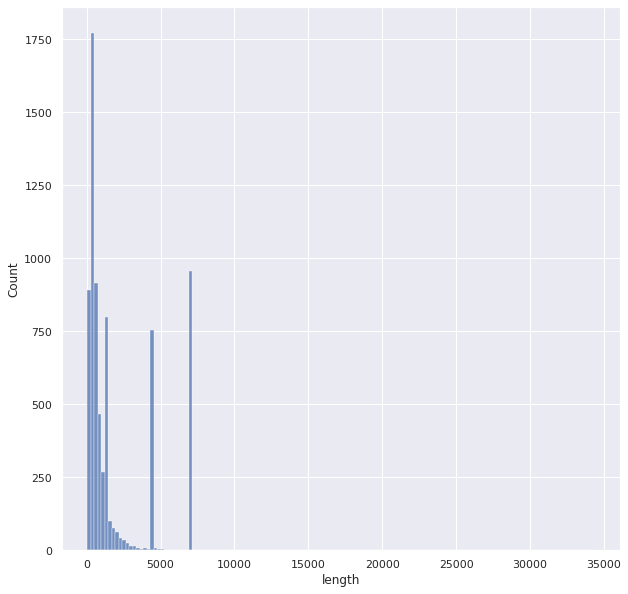

In [9]:
# histogram plot of sequences' length
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(df['length'], ax=ax)

In [10]:
# desc. stats of description
df.description.describe()

count                          7245
unique                         4153
top       2'-O-methyltransferase OS
freq                            809
Name: description, dtype: object

In [11]:
# desc. stats of sequence
df.sequence.describe()

count                                                  7245
unique                                                 7201
top       RXAPHGHVMVELVAELEGIQYGRSGETLGVLVPHVGEIPVAYRKVL...
freq                                                      6
Name: sequence, dtype: object

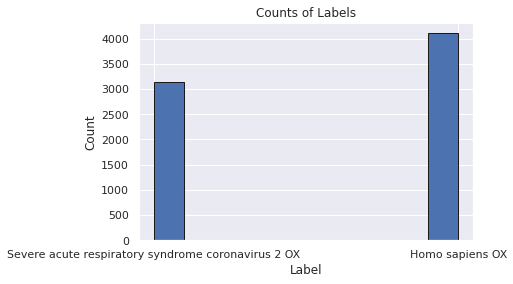

In [12]:
# value counts of category, to find out wether the data imbalance or not
plt.hist(df.category, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

In [13]:
# desc. stats of length
df.length.describe()

count     7245.000000
mean      1962.365079
std       2393.274102
min         25.000000
25%        406.000000
50%        748.000000
75%       2699.000000
max      34350.000000
Name: length, dtype: float64

In [14]:
# max length of 99% quantile data
maxlength = int(df.length.quantile(0.99))
maxlength

7096

## Preprocessing

In [15]:
# transform label to binary
dx = df[['sequence','category']].copy()
lb = LabelBinarizer()
dx['category'] = lb.fit_transform(dx['category'])

In [16]:
tokenizer = Tokenizer(char_level=True)

In [17]:
tokenizer.fit_on_texts(dx.sequence.values)
x = tokenizer.texts_to_sequences(dx.sequence.values)
x = sequence.pad_sequences(x, maxlen=maxlength)

In [18]:
fs = ElasticNet()
fs.fit(x,dx.category.values)

ElasticNet()

In [19]:
# importance value of features
importance = fs.coef_
np.unique(importance)

array([-0.00360533, -0.00278628, -0.00246416, -0.0019132 , -0.00186833,
       -0.00157084, -0.00078169, -0.00062731, -0.00046855,  0.        ,
        0.00036757,  0.00080638,  0.00091615,  0.0010412 ,  0.00157882,
        0.00218539,  0.00250739,  0.00285551,  0.00303181,  0.00677662,
        0.0072493 ,  0.01853464])

In [20]:
# selected features withvalue > 0
sf = list(np.array(np.where(importance>0))[0])
sf

[3336, 3665, 5871, 5879, 5975, 6083, 6722, 7002, 7006, 7032, 7063, 7065]

In [21]:
# selected features data
X = x[:,sf]

# print out the shape of selected features data
X.shape

(7245, 12)

In [22]:
# print out label shape
y = np.array(dx.category)
y.shape

(7245,)

In [23]:
# split data for training and testing
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

## Training

In [24]:
# define LGBMClassifier model and show the default parameters
model = lgb.LGBMClassifier(verbose=-1, force_col_wise=True)
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'force_col_wise': True}

In [25]:
np.log(3)

1.0986122886681098

In [26]:
# search space
space = {
    'class_weight': Categorical([None, 'balanced']),
    'boosting_type': Categorical(['gbdt', 'goss','dart']),
    'num_leaves': Integer(30,50),
    'learning_rate': Real(0.005, 0.2, 'log-uniform'),
    'subsample_for_bin': Integer(20000, 300000),
    'min_child_samples': Integer(20, 500),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0, 1),
    'colsample_bytree': Real(0.6, 1),
}

In [27]:
# bayesian optimization over hyper parameters
optimization = BayesSearchCV(model, space, n_iter=20, random_state=0)
optimization.fit(x_train,y_train)

BayesSearchCV(estimator=LGBMClassifier(force_col_wise=True, verbose=-1),
              n_iter=20, random_state=0,
              search_spaces={'boosting_type': Categorical(categories=('gbdt', 'goss', 'dart'), prior=None),
                             'class_weight': Categorical(categories=(None, 'balanced'), prior=None),
                             'colsample_bytree': Real(low=0.6, high=1, prior='uniform', transform='identity'),
                             'learning_rate': Real...
                             'min_child_samples': Integer(low=20, high=500, prior='uniform', transform='identity'),
                             'num_leaves': Integer(low=30, high=50, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'subsample_for_bin': Integer(low=20000, high=300000, p

## Results

In [28]:
# score
print('val. score :',optimization.best_score_)
print('test score :',optimization.score(x_test,y_test))

val. score : 0.9910282953761215
test score : 0.9937888198757764


In [29]:
# best parameters
optimization.best_params_

OrderedDict([('boosting_type', 'gbdt'),
             ('class_weight', 'balanced'),
             ('colsample_bytree', 0.8471984215264478),
             ('learning_rate', 0.2),
             ('min_child_samples', 20),
             ('num_leaves', 33),
             ('reg_alpha', 0.24280627512244907),
             ('reg_lambda', 0.9217548172035158),
             ('subsample_for_bin', 240163)])